In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR
MONTH = 21
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2017-12-31'
sns.set_style('whitegrid')
idx = pd.IndexSlice # Slicing the index (ex- idx['2018':'2023'])

ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
DATA_STORE = 'data/assets.h5'

In [2]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices'].loc[idx[START:END, :], ohlcv].rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000)).swaplevel().sort_index())

    stocks = (store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']])

In [3]:
stocks.tail()

,marketcap,ipoyear,sector
ticker,,,
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation
ZUO,3.040000e+09,2018.0,Technology
ZYME,4.868100e+08,2017.0,Health Care


In [4]:
prices.tail()

open   close    low   high   volume
ticker date                                            
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585
       2017-12-26  21.45  21.850  21.45  22.20  213.951
       2017-12-27  21.80  21.150  20.95  22.25  227.325
       2017-12-28  21.20  21.200  21.05  21.45  162.070
       2017-12-29  21.25  20.825  20.80  21.45  222.040

In [34]:
import FinanceDataReader as fdr

start_date = '2003-01-01'
end_date = '2023-04-09'
# df = fdr.StockListing('NYSE')
# df
# column=['open', 'high', 'low', 'adj close', 'volume']
df_stocks = fdr.DataReader('XOM', start_date, end_date).rename(columns=str.lower)
df_stocks['ticker'] = 'XOM'
df_stocks.index.rename('date', inplace=True)
df_stocks.reset_index(inplace=True)
df_stocks.set_index(['ticker', 'date'], inplace=True)
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5101 entries, ('XOM', Timestamp('2003-01-02 00:00:00')) to ('XOM', Timestamp('2023-04-06 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5101 non-null   float64
 1   high       5101 non-null   float64
 2   low        5101 non-null   float64
 3   close      5101 non-null   float64
 4   adj close  5101 non-null   float64
 5   volume     5101 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 423.2+ KB


In [5]:
# for over 2 years data
min_obs = 2 * YEAR

nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

In [6]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'
stocks.head()

,marketcap,ipoyear,sector
ticker,,,
PIH,43090000.0,2014.0,finance
PIHPP,NaN,NaN,finance
TURN,70330000.0,NaN,finance
FLWS,833390000.0,1999.0,consumer_services
FCCY,178140000.0,NaN,finance


In [7]:
# take common data btw stocks.index and prices.index
shared = (prices.index.get_level_values('ticker').unique().intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [8]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [9]:
stocks.sector.value_counts()

consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: sector, dtype: int64

In [10]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker').rolling(window=21).mean()).values

In [11]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  2857273 non-null  float64
dtypes: float64(7)
memory usage: 166.9+ MB


In [12]:
prices['dollar_vol_rank'] = (prices.groupby('date').dollar_vol_1m.rank(ascending=False))

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI) # default timeperiod: 14
prices.tail()

open   close    low   high   volume  dollar_vol  \
ticker date                                                           
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585  4495.59825   
       2017-12-26  21.45  21.850  21.45  22.20  213.951  4674.82935   
       2017-12-27  21.80  21.150  20.95  22.25  227.325  4807.92375   
       2017-12-28  21.20  21.200  21.05  21.45  162.070  3435.88400   
       2017-12-29  21.25  20.825  20.80  21.45  222.040  4623.98300   

                   dollar_vol_1m  dollar_vol_rank        rsi  
ticker date                                                   
ZUMZ   2017-12-22   11930.001226           1288.0  61.077094  
       2017-12-26   11963.373076           1291.0  63.799097  
       2017-12-27   11786.938512           1293.0  56.369727  
       2017-12-28   11290.208650           1300.0  56.757082  
       2017-12-29   10790.612631           1312.0  52.959469

Text(0.5, 1.0, 'RSI Distribution with Signal Threshold')

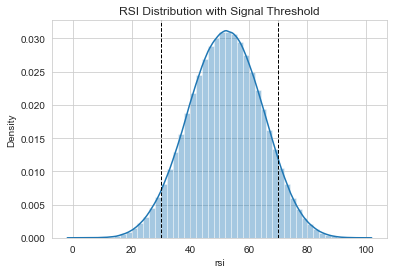

In [14]:
ax = sns.distplot(prices.rsi.dropna())
# draw threshold 30 and 70
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')

Text(0.5, 1.0, 'RSI Distribution with Signal Threshold')

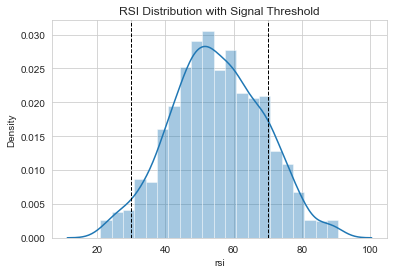

In [15]:
ax = sns.distplot(prices[prices.index.get_level_values('ticker') == 'AAPL'].rsi.dropna()) # check only AAPL
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')

In [16]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high':high, 'bb_mid':mid, 'bb_low':low}, index=close.index)

In [17]:
prices = (prices.join(prices.groupby(level='ticker').close.apply(compute_bb)))
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

<Axes: xlabel='bb_high', ylabel='Density'>

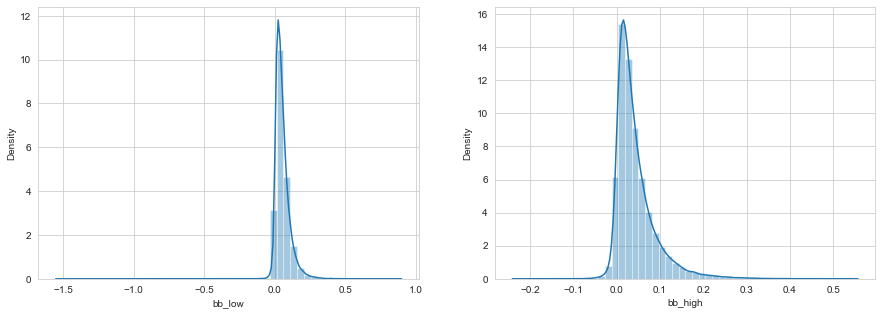

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])

In [19]:
# Average True Range: ranking by stock_data.close standardization
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

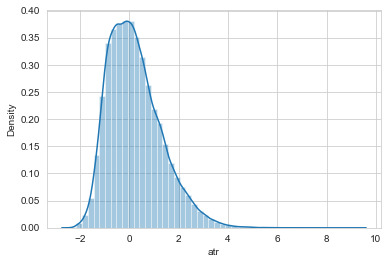

In [20]:
prices['atr'] = (prices.groupby('ticker', group_keys=False).apply(compute_atr))
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

In [21]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [22]:
prices['macd'] = (prices.groupby('ticker', group_keys=False).close.apply(compute_macd))
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean             0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

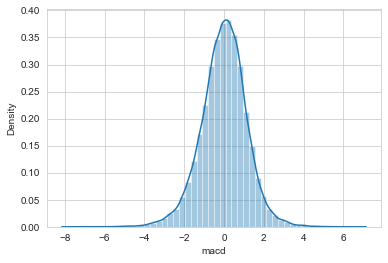

In [23]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

In [24]:
lags = [1, 5, 10, 21, 42, 63] # trading days by 1day,1wk, 2wk, 1m, 2m, 3m
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[1:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
mean,0.08%
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%


In [25]:
q = 0.0001

for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close.pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),upper=x.quantile(1 - q)))
                                .add(1).pow(1 / lag).sub(1))

for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

prices = prices.join(stocks[['sector']])
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
 8   rsi              2871361 non-null  float64
 9   bb_high          2859618 non-null  float64
 10  bb_mid           2859621 non-null  float64
 11  bb_low           2859585 non-null  float64
 12  atr              2871361 non-null  float64
 13  macd             2826749 non-null  float64
 14  return_1d        2901885 non-null  float6

In [27]:
prices.tail()

open   close    low   high   volume  dollar_vol  \
ticker date                                                           
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585  4495.59825   
       2017-12-26  21.45  21.850  21.45  22.20  213.951  4674.82935   
       2017-12-27  21.80  21.150  20.95  22.25  227.325  4807.92375   
       2017-12-28  21.20  21.200  21.05  21.45  162.070  3435.88400   
       2017-12-29  21.25  20.825  20.80  21.45  222.040  4623.98300   

                   dollar_vol_1m  dollar_vol_rank        rsi   bb_high  ...  \
ticker date                                                             ...   
ZUMZ   2017-12-22   11930.001226           1288.0  61.077094  0.028426  ...   
       2017-12-26   11963.373076           1291.0  63.799097  0.010058  ...   
       2017-12-27   11786.938512           1293.0  56.369727  0.040577  ...   
       2017-12-28   11290.208650           1300.0  56.757082  0.039229  ...   
       2017-12-29   10790.612631           1312.0  52.959469  0.050887  ...   

                   return_5d_lag5  return_10d_lag5  return_21d_lag5  \
ticker date                                                           
ZUMZ   2017-12-22        0.001647         0.003633         0.001177   
       2017-12-26        0.000000        -0.000856         0.001556   
       2017-12-27        0.010119        -0.005377         0.003478   
       2017-12-28        0.017985        -0.008980         0.001167   
       2017-12-29        0.007702        -0.012096         0.002110   

                   target_1d  target_5d  target_10d  target_21d  \
ticker date                                                       
ZUMZ   2017-12-22   0.018648        NaN         NaN         NaN   
       2017-12-26  -0.032037        NaN         NaN         NaN   
       2017-12-27   0.002364        NaN         NaN         NaN   
       2017-12-28  -0.017689        NaN         NaN         NaN   
       2017-12-29        NaN        NaN         NaN         NaN   

                              sector  year  month  
ticker date                                        
ZUMZ   2017-12-22  consumer_services  2017     12  
       2017-12-26  consumer_services  2017     12  
       2017-12-27  consumer_services  2017     12  
       2017-12-28  consumer_services  2017     12  
       2017-12-29  consumer_services  2017     12  

[5 rows x 47 columns]

In [28]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data/data.h5','model_data/no_dummies')

# get_dummies(DataFrame, column in DataFrame, prefix of dummy columns, separate char)
# drop_first=True : dummy coding / False : one-hot encoding
prices = pd.get_dummies(prices, columns=['year', 'month', 'sector'], prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''], drop_first=True)

prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 70 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   2904233 non-null  float64
 1   close                  2904233 non-null  float64
 2   low                    2904233 non-null  float64
 3   high                   2904233 non-null  float64
 4   volume                 2904233 non-null  float64
 5   dollar_vol             2904233 non-null  float64
 6   dollar_vol_1m          2857273 non-null  float64
 7   dollar_vol_rank        2857273 non-null  float64
 8   rsi                    2871361 non-null  float64
 9   bb_high                2859618 non-null  float64
 10  bb_mid                 2859621 non-null  float64
 11  bb_low                 2859585 non-null  float64
 12  atr                    2871361 non-null  float64
 13 

In [33]:
prices.tail()

open   close    low   high   volume  dollar_vol  \
ticker date                                                           
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585  4495.59825   
       2017-12-26  21.45  21.850  21.45  22.20  213.951  4674.82935   
       2017-12-27  21.80  21.150  20.95  22.25  227.325  4807.92375   
       2017-12-28  21.20  21.200  21.05  21.45  162.070  3435.88400   
       2017-12-29  21.25  20.825  20.80  21.45  222.040  4623.98300   

                   dollar_vol_1m  dollar_vol_rank        rsi   bb_high  ...  \
ticker date                                                             ...   
ZUMZ   2017-12-22   11930.001226           1288.0  61.077094  0.028426  ...   
       2017-12-26   11963.373076           1291.0  63.799097  0.010058  ...   
       2017-12-27   11786.938512           1293.0  56.369727  0.040577  ...   
       2017-12-28   11290.208650           1300.0  56.757082  0.039229  ...   
       2017-12-29   10790.612631           1312.0  52.959469  0.050887  ...   

                   consumer_durables  consumer_non-durables  \
ticker date                                                   
ZUMZ   2017-12-22                  0                      0   
       2017-12-26                  0                      0   
       2017-12-27                  0                      0   
       2017-12-28                  0                      0   
       2017-12-29                  0                      0   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
ZUMZ   2017-12-22                  1       0        0            0   
       2017-12-26                  1       0        0            0   
       2017-12-27                  1       0        0            0   
       2017-12-28                  1       0        0            0   
       2017-12-29                  1       0        0            0   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
ZUMZ   2017-12-22              0                 0           0               0  
       2017-12-26              0                 0           0               0  
       2017-12-27              0                 0           0               0  
       2017-12-28              0                 0           0               0  
       2017-12-29              0                 0           0               0  

[5 rows x 70 columns]

In [34]:
prices.to_hdf('data/data.h5', 'model_data')

In [36]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4209.0,0.001126,0.010457,-0.067138,-0.003606,0.001051,0.006156,0.061889
"(30, 70]",107244.0,0.000446,0.007711,-0.170571,-0.003054,0.000650,0.004246,0.075653
"(70, 100]",10634.0,0.000018,0.006354,-0.087857,-0.002818,0.000145,0.003121,0.058570


-2.68% (0.00%)


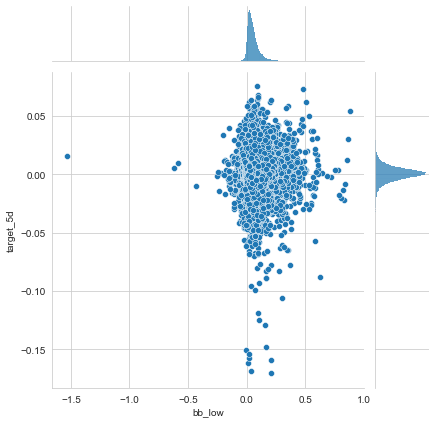

In [37]:
# B Bands
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

4.21% (0.00%)


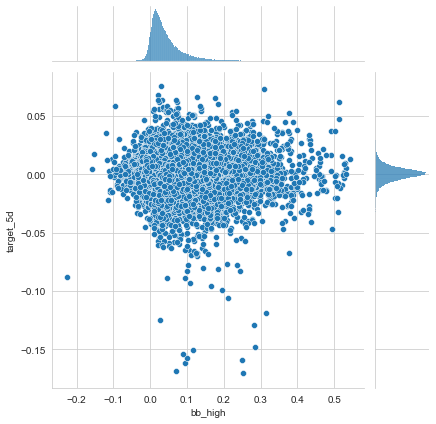

In [38]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

0.07% (80.08%)


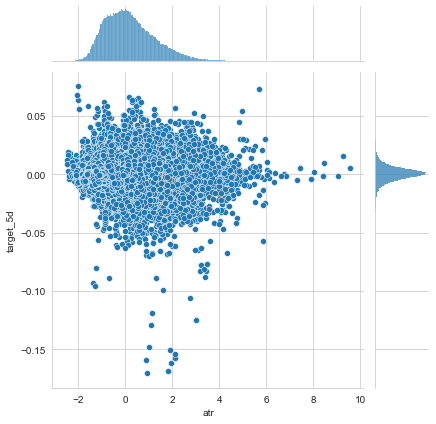

In [39]:
# ATR
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-4.72% (0.00%)


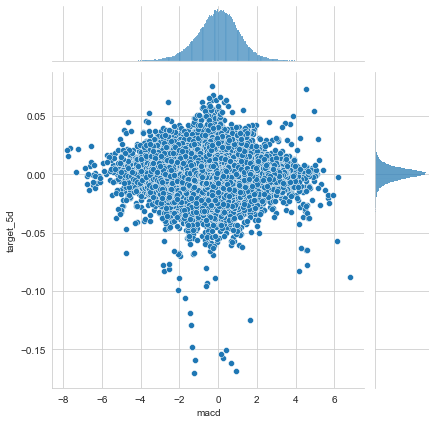

In [40]:
# MACD
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')